# ECG heart rhythm classifiers

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle

In [2]:
def show_ecg(ecg_label, rhythm_name, data, horizontal=5, vertical=2): 
    sample = data[data['ecg_rhythm'] == ecg_label]
    h = 0
    v = 0
    fig, axs = plt.subplots(vertical, horizontal, figsize=(horizontal*3, vertical*3))
    fig.suptitle(f'{rhythm_name}', fontsize=16)
    for i, x in sample.iloc[:(vertical*horizontal), :-1].iterrows():
        axs[v,h].plot(data.columns[:-1], x)
        h += 1
        if h == horizontal:
            v += 1
            h = 0
    
    plt.show()

In [3]:
def vizualize_data(data_for_vis, lables, vis_method):    
    df_for_vis = pd.DataFrame()
    df_for_vis[f'{vis_method}_dim_1'] = data_for_vis[:,0]
    df_for_vis[f'{vis_method}_dim_2'] = data_for_vis[:,1]
    df_for_vis['label'] = np.vstack(np.array(lables))
    
    plt.figure(figsize=(15,15))
    sns.scatterplot(data=df_for_vis, 
                    x=f'{vis_method}_dim_1', 
                    y=f'{vis_method}_dim_2', 
                    hue='label', 
                    legend='full', 
                    palette=sns.color_palette('hls', 5))
    
    plt.title(vis_method)
    plt.show()

In [4]:
def balance_data(X, y, classes_size = 10000, col='ecg_rhythm'):     
    data = pd.concat([X, y], axis = 1)
    data_balanced = pd.DataFrame()
    
    for i in np.sort(y.unique()):
        one_class = data[data[col] == i]
        df_one_class = resample(one_class, n_samples=classes_size, random_state=0)
        data_balanced = data_balanced.append(df_one_class)
        
    data_balanced = data_balanced.sample(frac=1)
    data_balanced.reset_index(drop=True, inplace=True)
    
    X = data_balanced.drop([col], axis=1)
    y = data_balanced.iloc[:,-1]
    
    return X, y

In [5]:
def noise_data(df):
    data = df.values
    noise_vec_size = data.shape[1]
    noise_vec = stats.norm(0,0.015).rvs(noise_vec_size)
    
    for i in np.arange(data.shape[0]):
        data[i,:] += noise_vec
        
    df_with_noise = pd.DataFrame(data, columns=df.columns)
    return df_with_noise

In [6]:
def show_metrics(model, labels, features, model_name=None):
    acc = accuracy_score(y_true=labels, y_pred=model.predict(features))
    cm = confusion_matrix(y_true=labels, y_pred=model.predict(features))
    df_confusion_matrix = pd.DataFrame(cm)
    plt.figure(figsize=(10,8))
    sns.heatmap(df_confusion_matrix/np.sum(df_confusion_matrix), annot=True, 
                fmt='.2%', cmap="Blues")
    plt.title(f'{model_name}')
    plt.show()
    
    print(f'{model_name} accuracy: {acc}')

In [7]:
def export_to_pickle(file, data):
    with open(f'./Pickle/{file}', mode="wb") as f:
        pickle.dump(data, f)

def load_from_pickle(file):
    with open(f'./Pickle/{file}', mode="rb") as f:
        data = pickle.load(f)
        
    return data

Data donlowded form Kaggle dataset "ECG Heartbeat Categorization Dataset":
https://www.kaggle.com/shayanfazeli/heartbeat

In [8]:
# loading data
FILE_TRAIN = r'./data_ecg/mitbih_train.csv'
FILE_TEST = r'./data_ecg/mitbih_test.csv'

df_train = pd.read_csv(FILE_TRAIN, header=None)
df_test = pd.read_csv(FILE_TEST, header=None)

# ECG column names from intigers to point in time
# ECG was registered with frequency odf 125 Hz, so every interval takes 0.008s
col = np.arange(0, 0.008*188, 0.008)

for df in (df_train, df_test):
    df.columns = col
    df.rename(columns={1.496:'ecg_rhythm'}, inplace=True)
    df.loc[:,'ecg_rhythm'] = df.loc[:,'ecg_rhythm'].astype(int)

# DataFrame for vizualization
df_vis = pd.concat([df_train, df_test], axis=0)
features_vis = df_vis.iloc[:, :-1]
labels_vis = df_vis.loc[:,'ecg_rhythm']

# Types of ECG rhythms in data
rhythm_types = ['Normal beat', 
'Supraventricular premature beat', 
'Premature ventricular contraction', 
'Fusion of ventricular and normal beat', 
'different beat']

## Data vizualization

Before we start to train the models let's visualize ECG data.

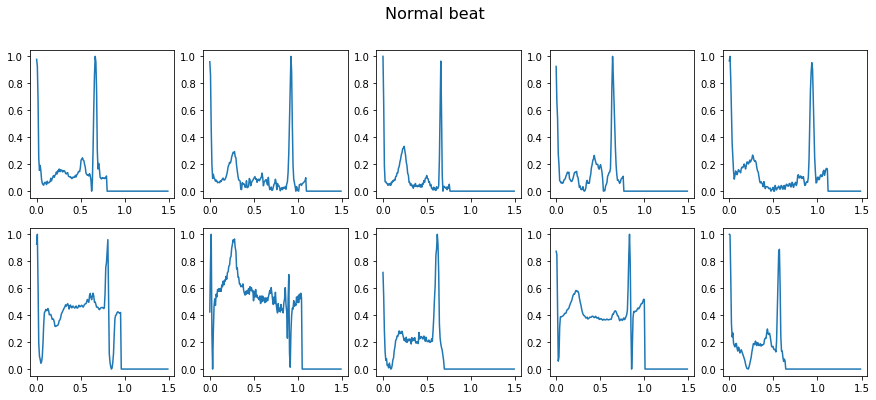

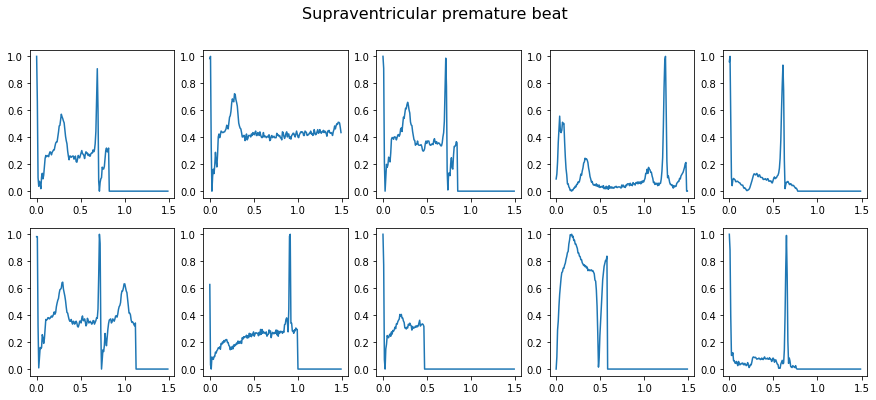

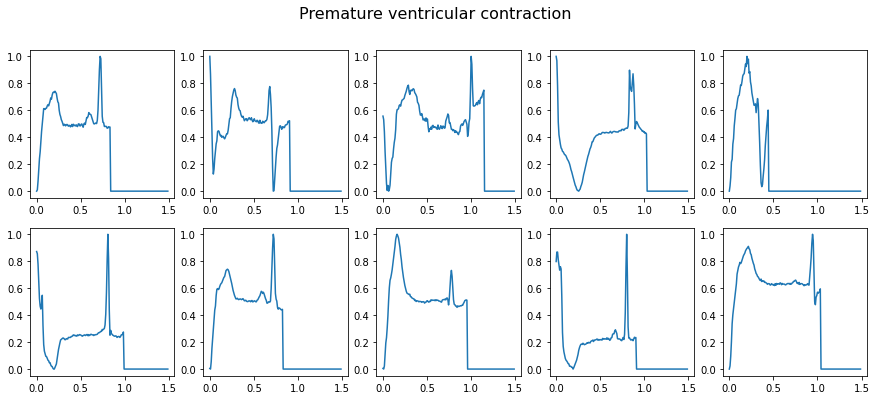

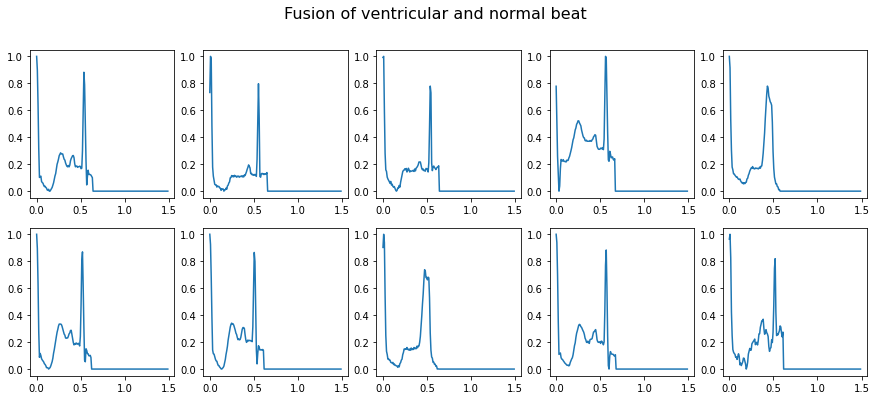

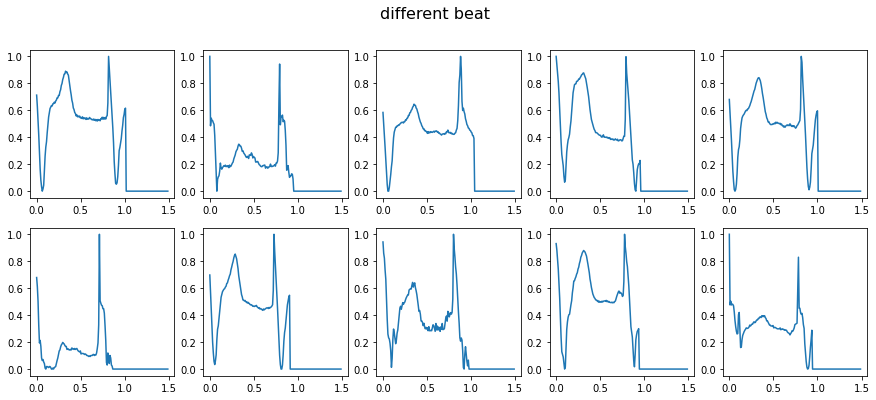

In [9]:
for i, rhythm in enumerate(rhythm_types):
    show_ecg(i, rhythm, data=df_vis)

## PCA

Every record in our data have 187 features, but let's see what will happen when we reduce dimensionality of our data to 2 dimensions using PCA method.

In [10]:
# scaler_vis = StandardScaler()
# pca_vis_2 = PCA(n_components=2)
# data_scaled_vis = scaler_vis.fit_transform(features_vis)
# data_2dim_vis = pca_vis_2.fit_transform(data_scaled_vis)
# export_to_pickle('pca2_with_scaler', data_2dim_vis)

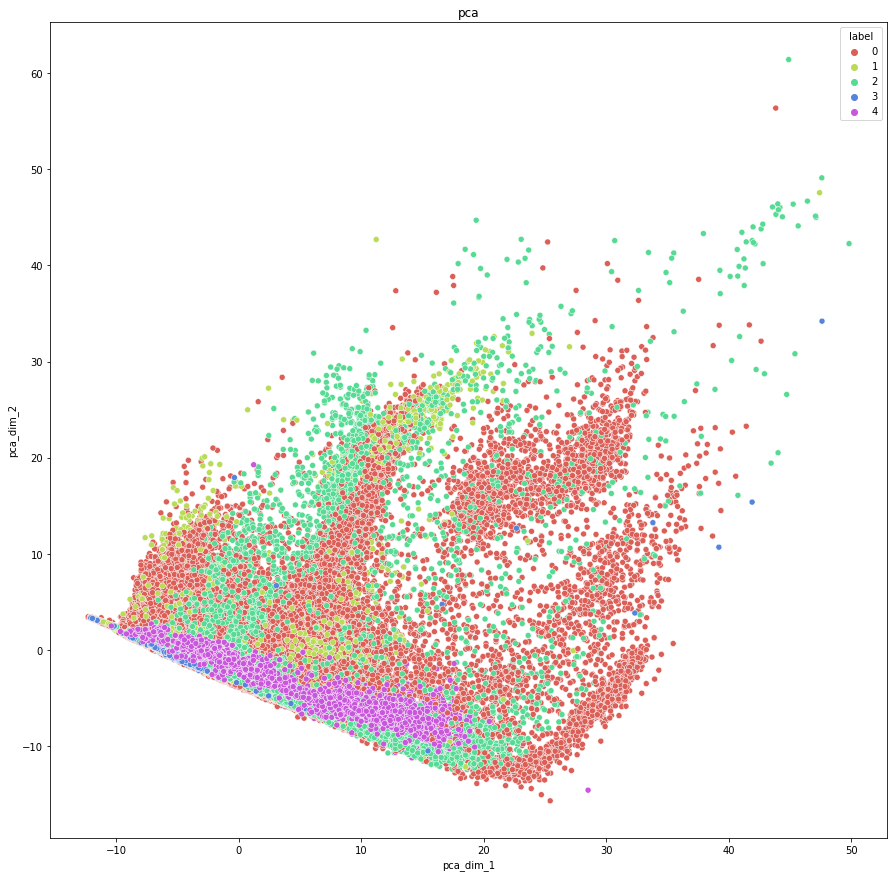

In [11]:
# 2 components PCA with scaling the data
data_2dim_vis = load_from_pickle('pca2_with_scaler')
vizualize_data(data_2dim_vis, labels_vis, 'pca')

In [12]:
# pca_2dim_without_scaler = PCA(2)
# data_2dim_without_scaler = pca_2dim_without_scaler.fit_transform(features_vis)
# export_to_pickle('pca2_without_scaler', data_2dim_without_scaler)

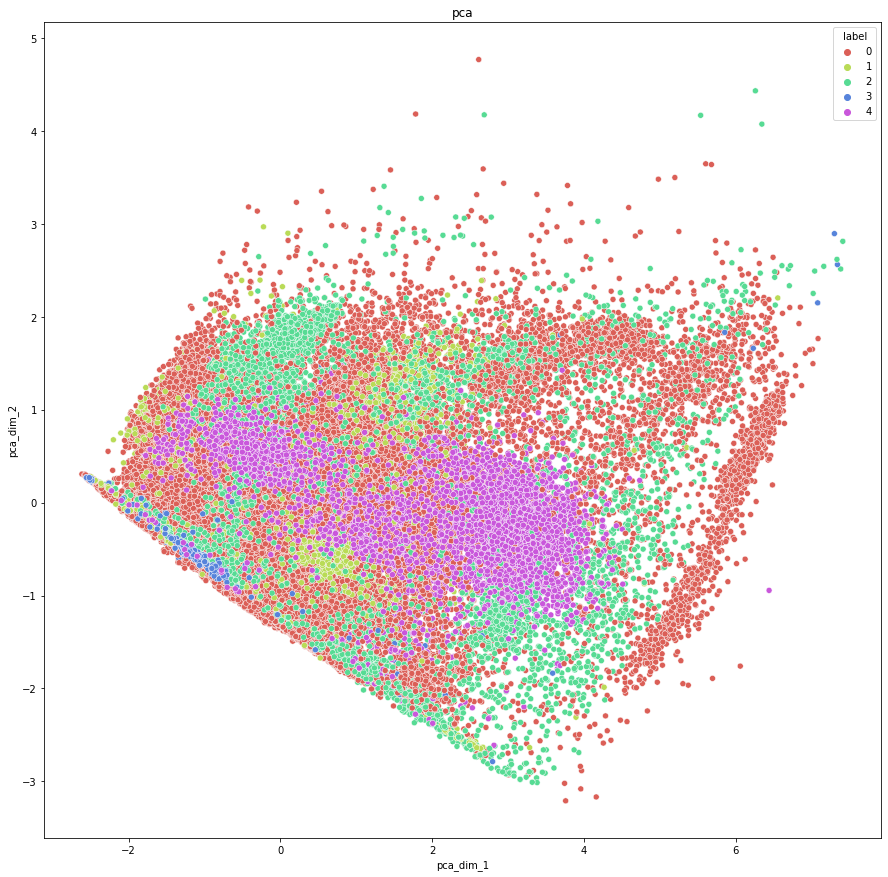

,0.0,0.008,0.016,0.024,0.032,0.04,0.048,0.056,0.064,0.07200000000000001,...,1.424,1.432,1.44,1.448,1.456,1.464,1.472,1.48,1.488,ecg_rhythm
count,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,...,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000
mean,0.891170,0.758909,0.424503,0.219602,0.201237,0.210298,0.205607,0.201617,0.198480,0.196610,...,0.004937,0.004568,0.004237,0.003914,0.003673,0.003469,0.003210,0.002956,0.002835,0.473439
std,0.239657,0.221190,0.227561,0.207248,0.177191,0.171965,0.178374,0.177020,0.171469,0.168028,...,0.043951,0.042109,0.040471,0.038801,0.037465,0.036552,0.035015,0.033413,0.032620,1.143232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.922252,0.682648,0.251014,0.048853,0.082418,0.088300,0.073171,0.066093,0.064893,0.068615,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991202,0.826560,0.430174,0.166355,0.147842,0.158640,0.145078,0.144465,0.150073,0.148849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910868,0.579832,0.342707,0.259045,0.287500,0.298343,0.295235,0.290623,0.283465,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [13]:
# 2 components PCA without scaling the data
data_2dim_without_scaler = load_from_pickle('pca2_without_scaler')
vizualize_data(data_2dim_without_scaler, labels_vis, 'pca')

df_vis.describe()

These two plots show visualization of ECG data using PCA with two components. The first plot shows our data after scaling it with StandardScaler. The second one was prepared without scaling the data. Because all the feature describes the same type of information (electrical voltage) and values of these feature are between 0 and 1 I have decided not to scale the data before training the models.

## t-SNE

It's hard to separate our data using linear PCA with only two dimensions, so I will try to visualize them using t-SNE. Before t-SNE let’s reduce dimensionality of ECG data with PCA to 30 dimensions.

In [14]:
# # t-SNE
# pca30_vis = PCA(n_components=30)
# ecg_30dim = pca30_vis.fit_transform(features_vis)
# data_tnse = TSNE(n_components=2, verbose=1).fit_transform(ecg_30dim)
# export_to_pickle('tsne2_pca30', data_tnse)

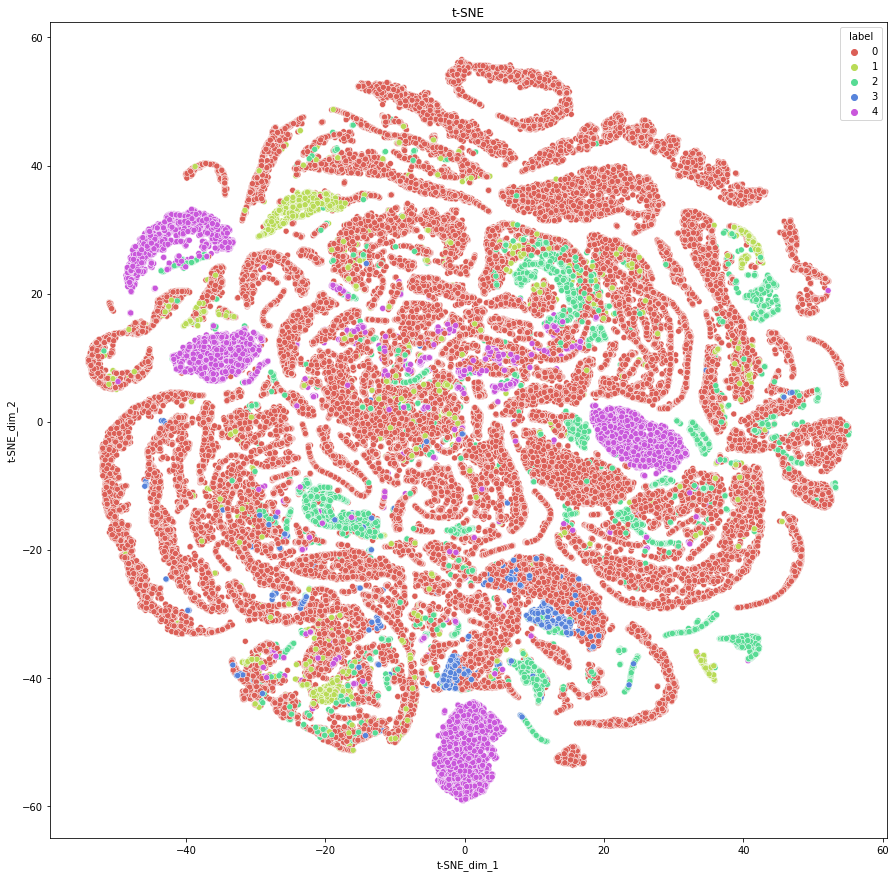

In [15]:
# t-SNE
data_tnse = load_from_pickle('tsne2_pca30')
vizualize_data(data_tnse, labels_vis, 't-SNE')

# Describsion of ECG data

In [16]:
# Shape and lack of ECG data
lack_of_data_train = df_train.isna().sum().sum()
lack_of_data_test = df_test.isna().sum().sum()
print(f'Shape of training data: {df_train.shape}')
print(f'Lack of training data: {lack_of_data_train}')
print(f'Shape of testing data: {df_test.shape}')
print(f'Lack of testing data: {lack_of_data_test}')

# percent of test data
test_percent = (df_test.shape[0]/(df_train.shape[0] + df_test.shape[0])) * 100
print(f'Percent of testing data: {test_percent:.2f} %')

Shape of training data: (87554, 188)
Lack of training data: 0
Shape of testing data: (21892, 188)
Lack of testing data: 0
Percent of testing data: 20.00 %


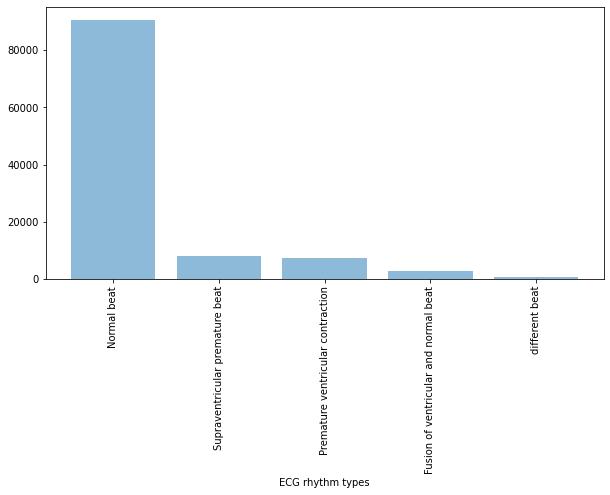

In [17]:
# classes in our data are unbalanced
classes = labels_vis.value_counts()
no_classes = len(classes)
plt.figure(figsize=(10,5))
plt.bar(range(no_classes), classes, alpha=0.5)
plt.xlabel('ECG rhythm types')
plt.xticks(np.arange(0,5), rhythm_types, rotation='vertical')

plt.show()

In [18]:
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (87554, 187)
X_test shape: (21892, 187)
y_train shape: (87554,)
y_test shape: (21892,)


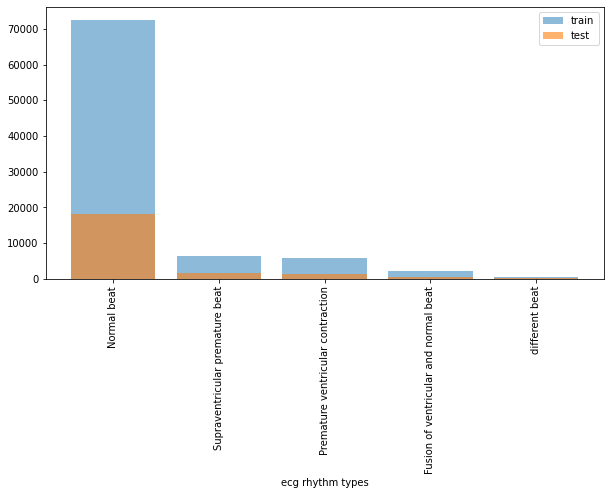

In [19]:
# 20% of each class is assigned to test data
plt.figure(figsize=(10,5))
plt.bar(rhythm_types, y_train.value_counts(), alpha=0.5, label="train")
plt.bar(rhythm_types, y_test.value_counts(), alpha=0.6, label="test")
plt.xlabel('ecg rhythm types')
plt.xticks(np.arange(0,5), rhythm_types, rotation='vertical')
plt.legend()
plt.show()

Because classes in training data are unbalanced we should equalize the count of records in each class before training the models.

In [20]:
# resampling data
X_train, y_train = balance_data(X_train, y_train)

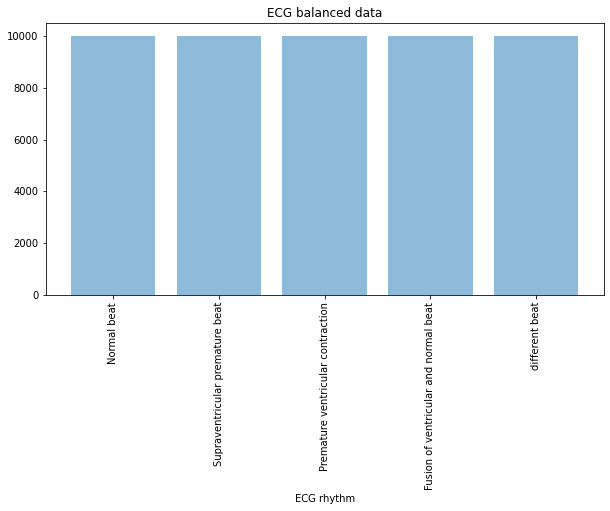

X_train shape: (50000, 187)
X_test shape: (21892, 187)
y_train shape: (50000,)
y_test shape: (21892,)


In [21]:
#shape of data after resampling
classes_balanced = y_train.value_counts()
no_classes = len(classes)
plt.figure(figsize=(10,5))
plt.bar(range(no_classes), classes_balanced, alpha=0.5)
plt.xlabel('ECG rhythm')
plt.xticks(np.arange(0,5), rhythm_types, rotation='vertical')
plt.title('ECG balanced data')
plt.show()

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

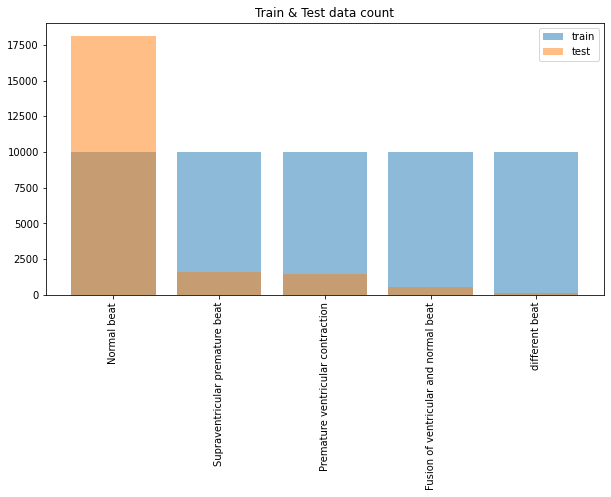

In [22]:
# comparing distribution of classes in training and testing data
plt.figure(figsize=(10,5))
plt.bar(range(no_classes), classes_balanced, alpha=0.5, label="train")
plt.bar(range(no_classes), y_test.value_counts(), alpha=0.5, label="test")
plt.xticks(np.arange(0,5), rhythm_types, rotation='vertical')
plt.legend()
plt.title('Train & Test data count')
plt.show()

After oversampling of some classes, some records are taken twice or more to our training data. To avoid overfitting we will add some noise to balanced ECG data.

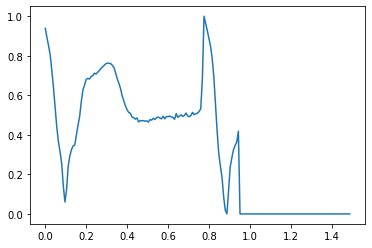

In [23]:
#data before adding noise
befor_noise = X_train.iloc[1]
befor_noise.plot()

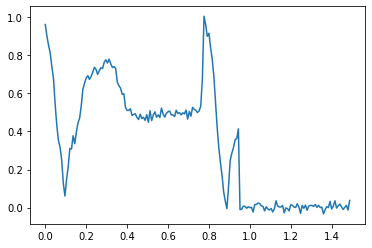

In [24]:
# adding noise to data
X_train = noise_data(X_train)

#data after adding noise
X_train.iloc[1].plot()
plt.show()

In [25]:
# balanced_noisy_training_data = (X_train, y_train)
# export_to_pickle('balanced_noisy_training_data', balanced_noisy_training_data)

In [26]:
# kfold = StratifiedKFold(n_splits=5)
# export_to_pickle('SKfold', kfold)
kfold = load_from_pickle('SKfold')

In [27]:
X_train, y_train = load_from_pickle('balanced_noisy_training_data')

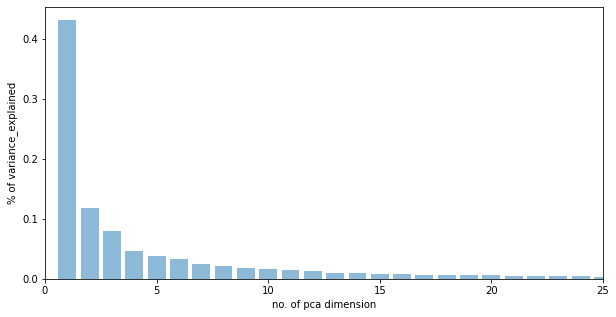

8 PCA dimesnions explained 79.37 % of variance


In [28]:
# pca decomposition
pca = PCA()
pca.fit(X_train)

plt.figure(figsize=(10,5))
plt.bar(range(1,1+pca.n_components_), pca.explained_variance_ratio_, alpha=0.5)
plt.xlim(0,25)
plt.xlabel('no. of pca dimension')
plt.ylabel('% of variance_explained')
plt.show()

eight_dim_var_expalined = np.sum(pca.explained_variance_ratio_[:8]) * 100
print(f'8 PCA dimesnions explained {eight_dim_var_expalined:.2f} % of variance')

PCA decomposition show us % of variance explained by different number of dimensions. According to barplot above 8 PCA dimensions explain almost 80% of variance in our data.
I have decided to use 8 PCA dimensions to train Logistic Regression and SVC models.

In [29]:
# pca dimension reduction
pca_8 = PCA(8)
pca.fit(X_train)
X_train_8 = pca.transform(X_train)
X_test_8 = pca.transform(X_test)

## Logistic Regression

Before training SVC and XGBoost let's train a baseline model.

In [30]:
##Baseline model
#LR = LogisticRegression(solver='saga', max_iter=1000)
#LR.fit(X_train_8, y_train)
#export_to_pickle('LR', LR)

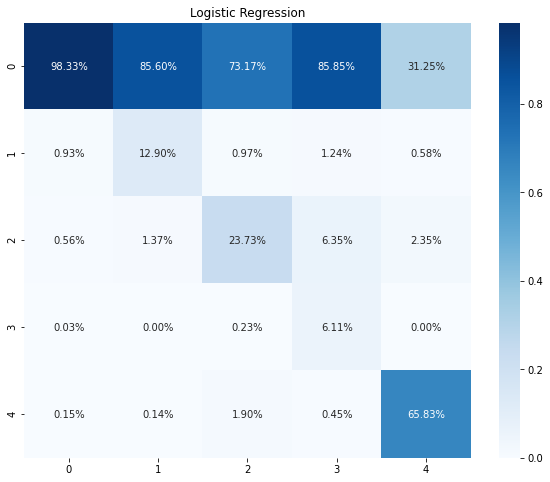

Logistic Regression accuracy: 0.5684725013703636


In [31]:
#Baseline model - Logistic Regression
LR = load_from_pickle('LR')
show_metrics(LR, y_test, X_test_8, model_name='Logistic Regression')

Accuracy of Logistic Regression model doesn't satisfy us. Our model classified well class 0, results of classification of class 4 was't very bad, but had a big problem with classification of class 1,2 and 3. Now, we will try to learn other models and look if we can obtain beter results. 

## SVM

In [32]:
## GridSearchCV - SVM kernel='rbf' 
# 
# svm_pipeline = Pipeline([('PCA', PCA(8)),
#                       ('clf', SVC(kernel='rbf'))])
# 
# svm_param_grid = {'clf__C': [0.1, 1, 10, 100, 1000, 10000, 100000],
#                   'clf__gamma': [0.1, 1, 10, 100, 1000]}
# 
# SVM_grid = GridSearchCV(estimator=svm_pipeline, 
#                         param_grid=svm_param_grid,
#                         cv = kfold,
#                         verbose=10,
#                         n_jobs=-1)
# 
# SVM_grid.fit(X_train, y_train)
# 
# export_to_pickle('SVM_new', SVM_grid)


Best C parameter: 1000
Best gamma parameter: 10



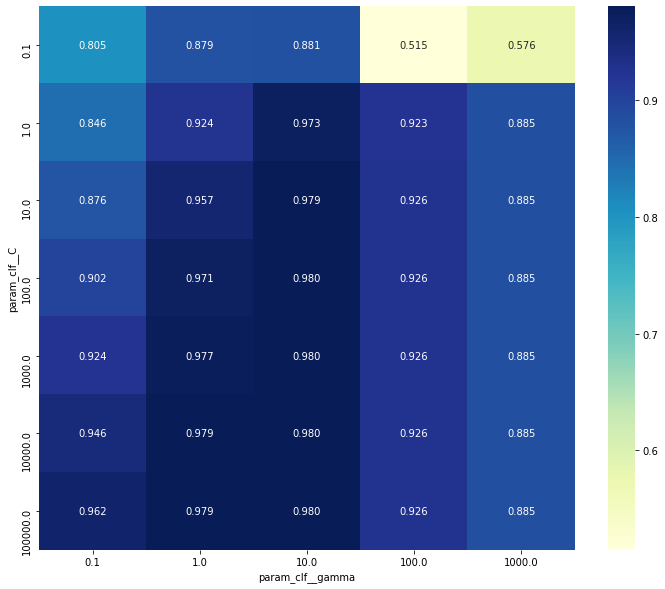

In [33]:
# heatmap of SVM classifier parameters
SVM_grid = load_from_pickle('SVM_new')
best_params_C = SVM_grid.best_params_['clf__C']
best_params_gamma = SVM_grid.best_params_['clf__gamma']

print(f'''
Best C parameter: {best_params_C}
Best gamma parameter: {best_params_gamma}
''')

cv_results_svm = pd.DataFrame(SVM_grid.cv_results_)
df_heatmap_SVM = cv_results_svm.loc[:, ['param_clf__C', 'param_clf__gamma', 'mean_test_score']]
df_heatmap_SVM = df_heatmap_SVM.pivot('param_clf__C', 'param_clf__gamma', 'mean_test_score')

plt.figure(figsize=(12,10))
ax =sns.heatmap(df_heatmap_SVM, annot=True, cmap="YlGnBu", fmt='.3f')
plt.show()

GridSearch and heatmap of SVM parameters show us that best SVM parameters to solve our ECG classification problem are C = 1000 and gamma = 10

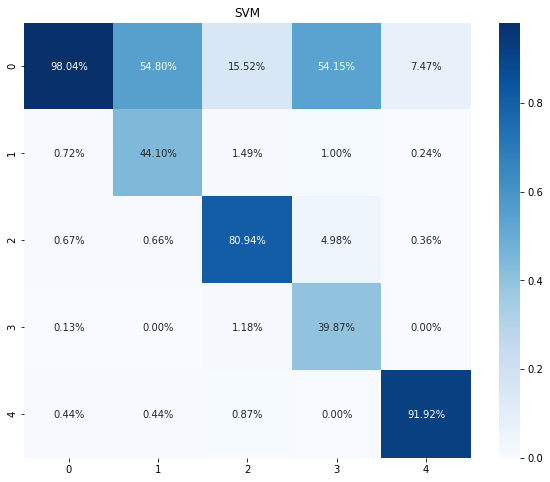

SVM accuracy: 0.9328521834460076


In [34]:
# confusion matrix and accuracy of SVM model
show_metrics(SVM_grid.best_estimator_, y_test, X_test, 'SVM')

With SVC we have obtained much beter results than with Logistic Regresion, but let's try if we can get beter results with XGBoost.

## XGBoost

In [35]:
## GridSearchCV - XGBoost GridSearchCV
# xgboost_model = Pipeline([('clf', XGBClassifier(booster='gbtree'))])
# 
# xgboost_param_grid = {'clf__n_estimators': [100,150,200],
#                       'clf__max_depth': [9,10,11, None],
#                       'clf__learning_rate': [0.25,0.5,1]
#                      }
# 
# xgboost_grid = GridSearchCV(estimator=xgboost_model, 
#                         param_grid=xgboost_param_grid,
#                         cv = kfold,
#                         verbose=10,
#                         n_jobs=-1)
# 
# xgboost_grid.fit(X_train, y_train)
# 
# export_to_pickle('xgboost_new', xgboost_grid)

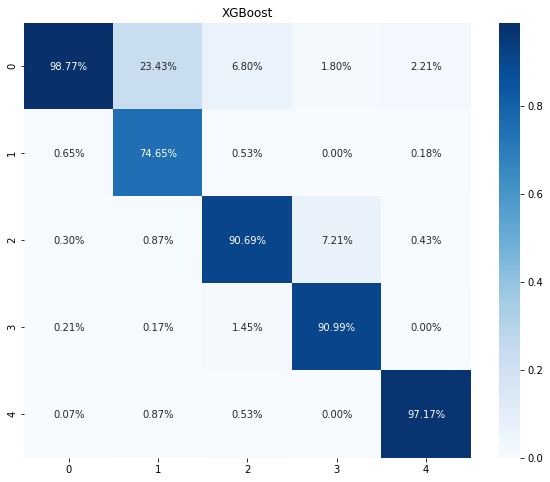

XGBoost accuracy: 0.9741914854741458


In [36]:
XGBoost_grid = load_from_pickle('xgboost_new')

# confusion matrix and accuracy of XGBoost model
show_metrics(XGBoost_grid.best_estimator_, labels=y_test, features=X_test, model_name='XGBoost')

XGBoost did a really good work. It classified properly not only 0, 2 and 4 classes, but also classes 1 and 3, which SVC model had problem with.

The diagrams below show us which features of ECG data were most important in classification of ECG by XGBoost model.

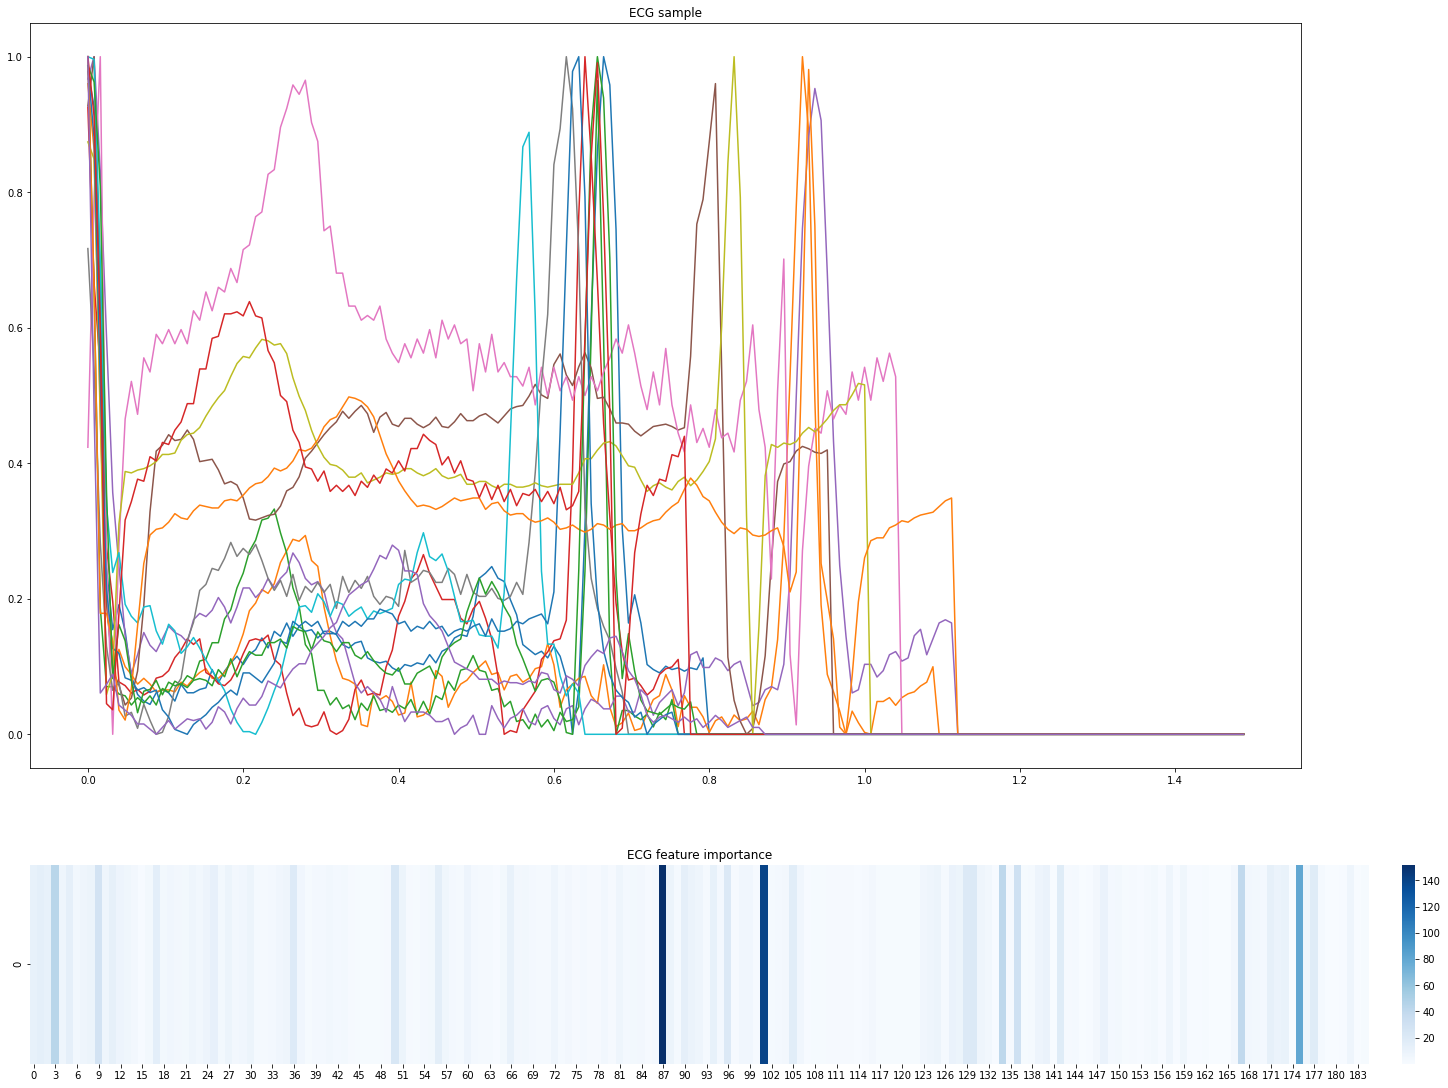

In [37]:
# feature importance of XGBoost model
XGBoost_model = XGBoost_grid.best_estimator_.steps[-1][-1]
XGB_feature_importance = XGBoost_model.get_booster().get_score(importance_type='gain')

f_importance_size = len(XGB_feature_importance)
f_importance_array = np.zeros([2*f_importance_size]).reshape(f_importance_size, 2)

for idx, (key, value) in enumerate(XGB_feature_importance.items()):
    f_importance_array[idx, 0] = key
    f_importance_array[idx, 1] = value

df_f_importance = pd.DataFrame(f_importance_array, columns=['feature', 'importance'])
df_f_importance.sort_values(by='feature', ascending=True, inplace=True)
df_f_importance.reset_index(drop=True, inplace=True)

importance_of_feature = df_f_importance.loc[:,'importance']

fig = plt.figure(figsize=(20,15), constrained_layout=True)
gs = fig.add_gridspec(20, 20)
ax1 = fig.add_subplot(gs[:15, :-1])
ax1.set_title('ECG sample')
ax2 = fig.add_subplot(gs[16:, :])
ax2.set_title('ECG feature importance')

importance_of_feature_array = np.array([importance_of_feature.values])
for i in np.arange(15):    
    ax1.plot(df_vis.iloc[i,:-1])
sns.heatmap(importance_of_feature_array, ax=ax2, cmap='Blues',annot_kws={'rotation': 90})
plt.show()